In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Q1:

## a. load the train data from TrainData.pkl

In [2]:
with open('TrainData.pkl', 'rb') as train_file:
    train_data = pickle.load(train_file)
with open('TestData.pkl', 'rb') as test_file:
    test_data = pickle.load(test_file)

In [3]:
labels_names = ["T-shirt/top", "Trouser", "Coat", "Sandal", "Ankle boot"]

In [4]:
X_train = train_data['X']
Y_train = train_data['Y']
X_test = test_data['X']
Y_test = test_data['Y']

## b. display 1 image from every y label

### extract the unique label values and the first index for each

In [5]:
index_first = []
labels = np.unique(Y_train)
for label in labels:
    index_first.append(np.where(Y_train == label)[0][0])

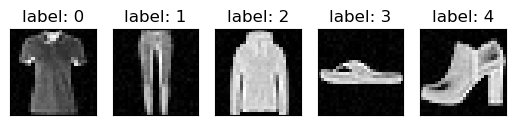

In [6]:
for i in range(len(index_first)):
    plt.subplot(1, len(index_first), i+1)
    plt.imshow(X_train[:, :, index_first[i]] ,cmap = "gray")
    plt.xticks([])
    plt.yticks([])
    plt.title('label: ' + str(labels[i]))
plt.show()

## c. reshape X to be num of samples x 784 instead of 28x28xnum of samples

In [7]:
# replace the order of dimensions before reshaping to the desired shape
X_train = X_train.transpose(2, 0, 1).reshape(24000, 784)
X_test = X_test.transpose(2, 0, 1).reshape(6000, 784)
print(X_train.shape)
print(X_test.shape)

(24000, 784)
(6000, 784)


# Q2:

## a: build a function to calculate the ML for all the parameters

#### change the data type to be float64 instead of uint8

In [8]:
X_train = X_train.astype(np.float64)

#### calculating and returning pi, expected value and variance of each label

In [9]:
def calc_params_ML(X, Y):
    pi_ML = []
    mu_ML = np.zeros((5, 784))
    sigma_squared_ML = np.zeros((5, 784, 784))
    for label in labels:
        selected_ExampleIDX = np.where(Y == label)[0]
        pi_ML.append(len(selected_ExampleIDX)/len(Y))
        mu_ML[label] += (np.sum(X[selected_ExampleIDX], axis=0)/len(X[selected_ExampleIDX]))
        sigma_X_dot_XT = np.zeros((784, 784))
        for i in range(len(selected_ExampleIDX)):
            sigma_X_dot_XT += X[i].reshape(784,1)@X[i].reshape(1,784)
        sigma_squared_ML[label] += (1/len(selected_ExampleIDX))*sigma_X_dot_XT - mu_ML[label].reshape(784, 1)@mu_ML[label].reshape(1, 784)
    return [pi_ML, mu_ML, sigma_squared_ML]

## B: build a classifier function and return vector Y predicted for all samples

In [10]:
def classify(X, mu, sigma_squared, pi):
    Y_classify = np.zeros((len(X),))
    pi_ln = np.zeros((5,))
    det_ln = np.zeros((5,))
    sigma_inv = np.zeros((5, 784, 784))
    for c in range(5):
        pi_ln[c] += np.log(pi[c])
        [sign, logabsdet] = np.linalg.slogdet(sigma_squared[c])
        det_ln[c] += sign * logabsdet
        sigma_inv[c] += np.linalg.inv(sigma_squared[c])

    for i in range(len(X)):
        likelyhood = []
        for c in range(5):
            likelyhood.append(pi_ln[c]-0.5*det_ln[c]-0.5*(X[i]-mu[c]).reshape(1,784)@sigma_inv[c]@(X[i]-mu[c]).reshape(784,1))
        Y_classify[i] += np.argmax(likelyhood)
    return Y_classify

## c: display the average vectors as an image for each of the labels

In [11]:
[pi_ML, mu_ML, sigma_squared_ML] = calc_params_ML(X_train, Y_train)

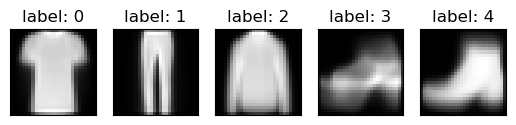

In [12]:
for c in range(5):
    plt.subplot(1, 5, c+1)
    plt.imshow(mu_ML[c].reshape(28,28) ,cmap = "gray")
    plt.xticks([])
    plt.yticks([])
    plt.title('label: ' + str(labels[c]))
plt.show()

# Q3:

## a: show the classifier's accuracy

In [13]:
def accuracy(Y_real, Y_pred):
    return np.sum(Y_pred == Y_real)/len(Y_pred)

In [14]:
Y_pred = classify(X_train, mu_ML, sigma_squared_ML, pi_ML)
print("The accuracy of the classifier for the train data is: " + str(accuracy(Y_train, Y_pred)))

The accuracy of the classifier for the train data is: 0.68975


## b: show the confusion matrix

In [15]:
def plotConfusionMatrix(cm, dataset_type):
    plt.figure(figsize=(6, 6))
    plt.title("Confusion Matrix for " + dataset_type)
    df_cm = pd.DataFrame(cm, index=[labels_names], columns=[labels_names])
    sn.heatmap(df_cm, annot=True, fmt=".0f", cbar=False)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

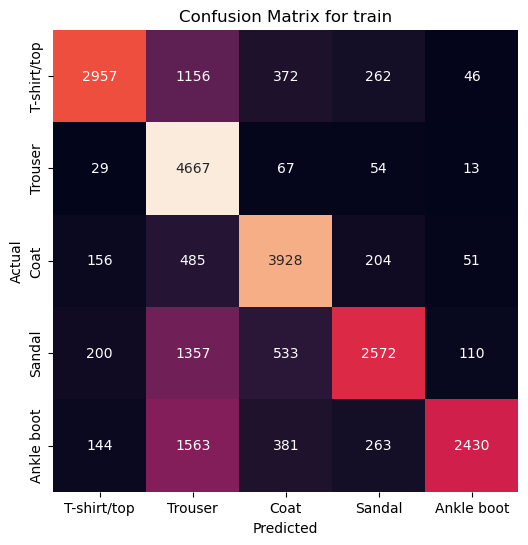

In [16]:
cm_train = confusion_matrix(Y_train, Y_pred)
plotConfusionMatrix(cm_train, "train")

## c: calculate and show the precision and recall for each label

In [17]:
def recall_and_precision(Y_real, Y_pred, true_label):
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(Y_real)):
        if Y_pred[i] == true_label:
            if Y_real[i] == true_label:
                tp += 1
            else:
                fp += 1
        elif Y_pred[i] != true_label and Y_real[i] == true_label:
            fn += 1
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    return [precision, recall]

In [18]:
print("Precision and Recall for the training data:")
for label in labels:
    [precision, recall] = recall_and_precision(Y_train, Y_pred, label)
    print("Label " + labels_names[label] + ":")
    print(f"Precision: {precision}, Recall: {recall}")

Precision and Recall for the training data:
Label T-shirt/top:
Precision: 0.8482501434308664, Recall: 0.616941372835385
Label Trouser:
Precision: 0.5057433896835717, Recall: 0.9662525879917184
Label Coat:
Precision: 0.7437985230070062, Recall: 0.814262023217247
Label Sandal:
Precision: 0.7666169895678092, Recall: 0.5389773679798826
Label Ankle boot:
Precision: 0.9169811320754717, Recall: 0.5082618699016942


# Q4: repeat Q3 for the test data

## a: show the classifier's accuracy

In [19]:
Y_pred = classify(X_test, mu_ML, sigma_squared_ML, pi_ML)
print("The accuracy of the classifier for the Test data is: " + str(accuracy(Y_test, Y_pred)))

The accuracy of the classifier for the Test data is: 0.667


## b: show the confusion matrix

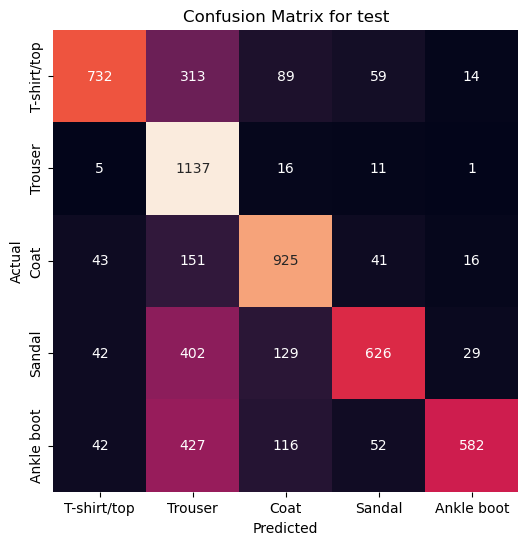

In [20]:
cm_train = confusion_matrix(Y_test, Y_pred)
plotConfusionMatrix(cm_train, "test")

## c: calculate and show the precision and recall for each label

In [21]:
print("Precision and Recall for the test data:")
for label in labels:
    [precision, recall] = recall_and_precision(Y_test, Y_pred, label)
    print("Label " + labels_names[label] + ":")
    print(f"Precision: {precision}, Recall: {recall}")

Precision and Recall for the test data:
Label T-shirt/top:
Precision: 0.8472222222222222, Recall: 0.6064623032311516
Label Trouser:
Precision: 0.4679012345679012, Recall: 0.9717948717948718
Label Coat:
Precision: 0.7254901960784313, Recall: 0.7865646258503401
Label Sandal:
Precision: 0.7934093789607097, Recall: 0.509771986970684
Label Ankle boot:
Precision: 0.9065420560747663, Recall: 0.4774405250205086
